# Hackathon Stat

This project illustrates the course LEPL1109 with an industrial application of statistics. You will analyse the capacity of solar production of electricity located in the French cities of Caen and Tours.
The file 'radiation.csv' contains 3 columns 
DATE           : YYYYMMDD,
Caen and Tours : the daily solar radiation in W/m2 measured in the 2 cities. 
Notice that data for some days are not reported due to failure of measurement system.

## Report content

•	You have to fill in this  jupyter notebook downloadable on the moodle website of the course

•	Grades are granted to the members whose names are in the Jupyter notebook. If your name doesn’t appear on the top of the notebook, you’ll get a 0, even though you are in a group on Moodle.

•	The jupyter notebook must be compiled with printed results and next submitted via moodle. The absence of compiled results (or non-printed values) leads to a lower grade.

## Report submission

•	The deadline for submission is reported on the moodle website. Submission after the deadline will not be accepted.

•	To submit your report, go to the section “APP” on Moodle and the subsection “Soumission du rapport”. You can upload your work there. Once you are sure that it is your final version, click the button “Envoyer le devoir”. It is important that you don’t forget to click on this button ! 

•	Reports that have not been uploaded through Moodle will not be corrected.

## Names and Noma of participants:

Part. 1: Lebras Floriane         (35022100)

Part. 2: Martin Antoine           (86692100)

Part. 3: Dallemagne Brieuc        (77122100)

Part. 4: De Vleeschouwver Nora    (48602100)

Part. 5: Debelle Thomas           ()

Part. 6: Orékhoff Alexandre       (54552100)

---
## 1. Energy calculation and basic statistics

Compute the daily energy in WH per square meter of solar panel. For this purpose you use the datasets reporting the solar irradation measure in Caen and Tours (source https://www.ecad.eu/). The irradiation is measured in W/m2 per day. You will use the formula:

C = E_Sol x 24 x P_cr x f_perf

where  

C is the electricity produced in WH/m2 for a day

E_sol is the daily solar radiation in W/m2 

P_cr is the peak power coefficient, set here to  0.18 (monocristal silicium)

f_perf depends upon the system, set here to 0.75.

Remark:

1 W = 1 J/sec

1 WH  is 1W x 3600sec = 3600J

energy/m2 = E_sol * 24 * 3600 J/m2 = E_sol * 24 WH/m2

---
1.1. Start by computing the daily energy in WH produced by a 1m2 solar panel

a. Plot time-series of solar electric production in Caen and Tours from 1974 to 2023. Comment the evolution.

b. Plot boxplots of daily productions for both cities. Comment the box plot.

c. Remove outliers using the interquartile range. 

d. Plot an histogram of daily electricity production, after removal of outliers.

Watchout: remove all days for which a outlier is observed in Caen **or** Tours to keep the same number of observations.


In [41]:
### prérequis ###

import csv
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm

# lire le fichier csv
with open('Radiation.csv', 'r') as rad:
    reader = csv.reader(rad)
    data = list(reader)

#enlever la premiere ligne 
data = data[1:]

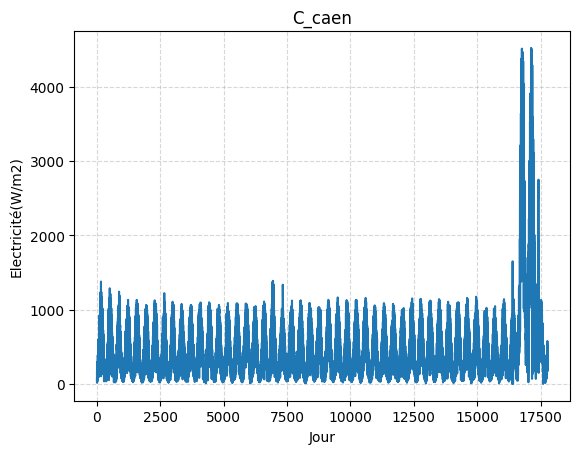

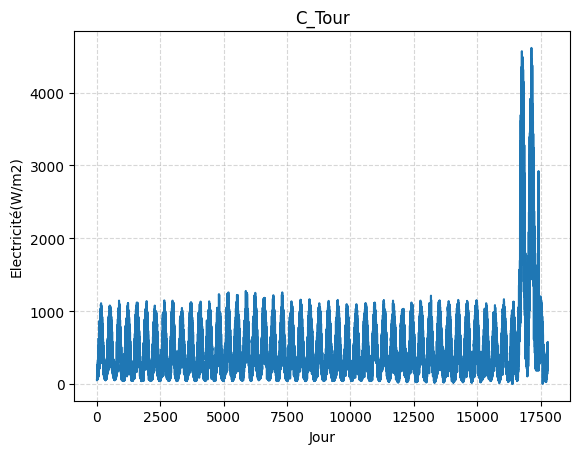

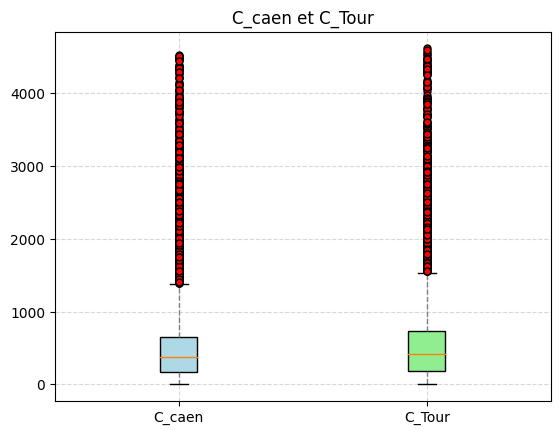

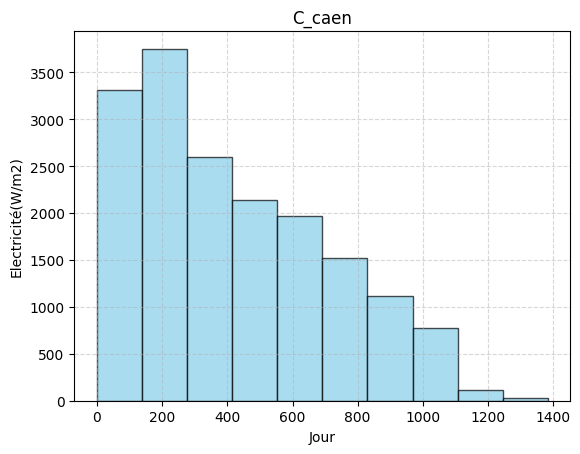

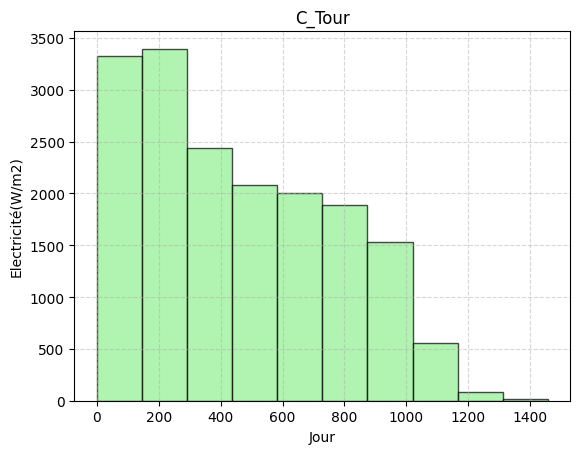

In [59]:
### code 1.1 ###

P_cr = 0.18
f_perf = 0.75
E_caen = list()
E_Tour = list()
C_caen = list()
C_Tour = list()
for lst in data:
    E_caen.append(int(lst[2]))
    E_Tour.append(int(lst[3]))
    C_caen.append(24*int(lst[2])*P_cr*f_perf)
    C_Tour.append(24*int(lst[3])*P_cr*f_perf)

def box_plot(data1, data2, title, name1, name2):
    plt.figure()
    bp = plt.boxplot([data1, data2], patch_artist=True, labels=[name1, name2])
    
    colors = ['lightblue', 'lightgreen']
    for box, color in zip(bp['boxes'], colors):
        box.set(facecolor=color)
    
    for whisker in bp['whiskers']:
        whisker.set(color='gray', linestyle='--', linewidth=1)
    
    for flier in bp['fliers']:
        flier.set(marker='o', markersize=5, markerfacecolor='red')
    
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


def plot_data(data,title,Xname,Yname):
    plt.figure()
    plt.plot(data)
    plt.title(title)
    plt.xlabel(Xname)
    plt.ylabel(Yname)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

def remove_outliers_interquartile(lst1,lst2):
    q1 = np.percentile(lst1, 25)
    q3 = np.percentile(lst1, 75)
    iqr = q3 - q1
    Q1 = np.percentile(lst2,25)
    Q3 = np.percentile(lst2,75)
    new_lst1 = list()
    new_lst2 = list()
    for i in range(len(lst1)):
        if lst1[i] > q1 - 1.5*iqr and lst1[i] < q3 + 1.5*iqr and lst2[i] > Q1 - 1.5*iqr and lst2[i] < Q3 + 1.5*iqr:
            new_lst1.append(lst1[i])
            new_lst2.append(lst2[i])
    return new_lst1,new_lst2

def plot_histogram(data, title, x_label, y_label, bins=10, color='skyblue'):
    plt.figure()
    plt.hist(data, bins=bins, color=color, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.show()

plot_data(C_caen,'C_caen','Jour','Electricité(W/m2)')
plot_data(C_Tour,'C_Tour','Jour','Electricité(W/m2)')

box_plot(C_caen,C_Tour,'C_caen et C_Tour','C_caen','C_Tour')

C_caen,C_Tour = remove_outliers_interquartile(C_caen,C_Tour)

plot_histogram(C_caen,'C_caen','Jour','Electricité(W/m2)')
plot_histogram(C_Tour,'C_Tour','Jour','Electricité(W/m2)',color='lightgreen')



---
1.2. We want to compute monthly statistics of electricity solar production. Calculate for each city and for each month: 

1) the average daily production of electricity in Wh/m2

2) the median daily production of electricity in Wh/m2

3) the standard deviation daily production of electricity in Wh/m2

4) the 5% percentile of daily production of electricity in Wh/m2

5) the 95% percentile of daily production of electricity in Wh/m2

Report the results in one or two tables. 

Compare and comment these statistics!

In [43]:
### code 1.2 ###


---
## 2. Fit of distributions and hypothesis tests

---
2.1. We focus on the daily production of electricity in April. Retrieve the data for month of April, in Caen and Tours. 

 1) Fit Gamma and normal distributions by log-likelihood maximization to 
    daily production of electricity during April (Caen & Tours).
    
 2) Compute the 4 log-likelihoods and select the best model for each location (justify your answer).
 
 3) Compare on the same plot the empirical, the  gamma and normal pdf (the
    empirical pdf is an histogram of frequencies).
    
 4) Why is there 3 parameters in python for the Gamma pdf whereas there
    is only 2 in the distribution seen during lectures? 

Remark : set floc to -0.001 for the gamma.fit (to avoid troubles in case of null observations)


In [44]:
#code here


---

2.2. Check if the average daily production in April is the same in Caen and Tours. Let us recall that the null hypothesis is

$H_0$: $\mu_{Caen} = \mu_{Tours}$.

Take care to comment your conclusions. Are all assumptions required to perform this test sastisfied?

In [45]:
#code here


---
2.3. Test the equality of variance of daily production in April at Caen & Tours?
$H_0$: $\sigma_{Caen}=\sigma_{Tours}$.


In [46]:
#code here


---
2.4. Explain the Wilcoxon's test. What is the main advantage of this test compared to the Student's T test. Why is this useful in our project? 

---
2.5. Apply the Wilcoxon test to distributions of daily productions in April, at Caen and Tours.  What can you conclude about the means of daily production in these 2 cities?


In [47]:
#code here


---
## 3. Regression and forecasting 

---
3.1. Do we observe any trend in the yearly solar production of electricity over the considered period?
To answer this question: 

a. You will compute the average daily production (Wh/m2) during April from 1977 up to 2019 (included).

b. You get a time-series of 44 values for each city. Regress these values on the explanatory
variables X=(Year-1977). Don't forget to add a constant term and analyze results. 

c. Plot on the same graph, the predicted and the observed values.

d. Comment your results! 


In [48]:
#code here


---
3.2. You want to design a model to forecast the solar electric production for the next day (location Caen only). You will work with data over the period 1977 to 2019. 

Let us denote by C(t) the production on day 't'. The model that we want to fit is called autoregressive and is defined as follows:

$$C(t) = \sum_{k=1}^{10} a_k C(t-k) $$

This model is common in time-series analysis and predicts the production of the next day with the  recent observations.

a. Split the dataset into a training set (1977 to 2010 included) and a validation set (2011 to 2019 included).

b.	Estimate this model with statsmodels on the training set. 

c.	How would you judge the quality of the predictive model? (Analyze statistics reported by statsmodel)

d.	Compute the Mean Absolute Error (MAE) between predicted and real consumptions (on the training set).

In [49]:
#code here


---
3.3. Use this model on the test set to forecast the electric daily production.

a. Compare on a graph, the forecast to  real consumptions on the given period. 

b. Plot the errors of prediction. Are they acceptable?

c. Compute the MAE on the test set and the $R^2$. Is the forecast reliable?

In [50]:
# code here
